## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Overtraining

Here I train for 5000 steps. The resulting paths do not respect the potential (or the end constraint). 

old s 0.0
Train loss: 55244.9609375
Test loss is 80513.5625
OM of path 87.1908
old s 0.1
Train loss: 3229.18212890625
Test loss is 4662.966796875
OM of path 613.4784
old s 0.5
Train loss: 6777366.0
Test loss is 4161413.5
OM of path 185.68323


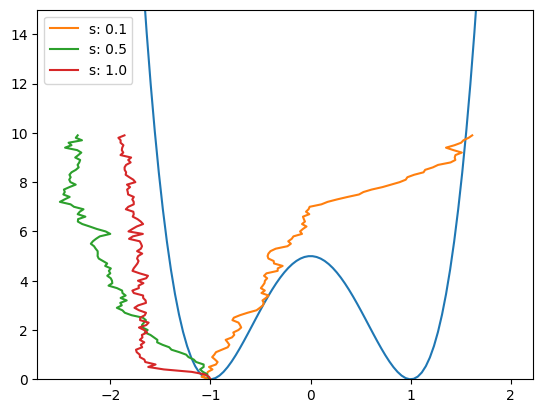

In [13]:
from path_sampling import dfdt, div_f, make_double_well_potential, update_non_amortized


key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
schedule = [0.1, 0.5, 1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]





def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 5000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

## Failure from dt too large

When dt is too large, numerical instability appears.

old s 0.0
Train loss: 167664.8125
Test loss is 256223.09375
OM of path 113.9815
old s 0.1
Train loss: 178704.28125
Test loss is 295135.46875
OM of path 204.60303
old s 0.5
Train loss: 10350.55078125
Test loss is 21044.396484375
OM of path 106.150955


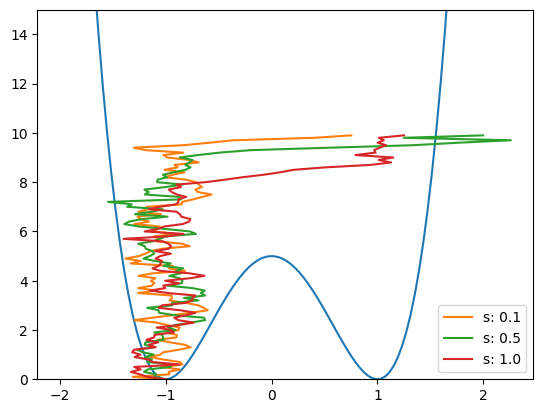

In [10]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
schedule = [0.1,0.5, 1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 10000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

old s 0.0
Train loss: 6402.6484375
Test loss is 24312.2578125
OM of path 95.0959
old s 0.1
Train loss: 43303.69140625
Test loss is 44987.203125
OM of path 133.92815
old s 0.5
Train loss: 4528.255859375
Test loss is 5649.22802734375
OM of path 73766.81


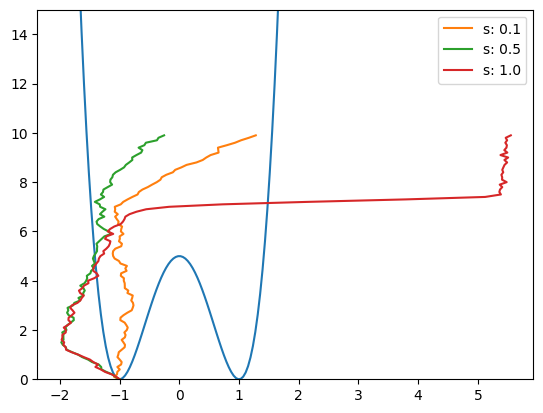

In [12]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
schedule = [0.1,0.5,1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



from path_sampling import dfdt, div_f, update, update_non_amortized


def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 10000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)